In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,3)

In [3]:
num_values = 7
degrees_week = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_week)
sin_week = np.sin(np.deg2rad(degrees_week))
print(sin_week)
cos_week = np.cos(np.deg2rad(degrees_week))
print(cos_week)

num_values = 12
degrees_month = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_month)
sin_month = np.sin(np.deg2rad(degrees_month))
print(sin_month)
cos_month = np.cos(np.deg2rad(degrees_month))
print(cos_month)

num_values = 31
degrees_day = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_day)
sin_day = np.sin(np.deg2rad(degrees_day))
print(sin_day)
cos_day = np.cos(np.deg2rad(degrees_day))
print(cos_day)

num_values = 24
degrees_hour = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_hour)
sin_hour = np.sin(np.deg2rad(degrees_hour))
print(sin_hour)
cos_hour = np.cos(np.deg2rad(degrees_hour))
print(cos_hour)

[   0.           51.42857143  102.85714286  154.28571429  205.71428571
  257.14285714  308.57142857]
[ 0.          0.78183148  0.97492791  0.43388374 -0.43388374 -0.97492791
 -0.78183148]
[ 1.          0.6234898  -0.22252093 -0.90096887 -0.90096887 -0.22252093
  0.6234898 ]
[   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.  330.]
[  0.00000000e+00   5.00000000e-01   8.66025404e-01   1.00000000e+00
   8.66025404e-01   5.00000000e-01   1.22464680e-16  -5.00000000e-01
  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01  -5.00000000e-01]
[  1.00000000e+00   8.66025404e-01   5.00000000e-01   6.12323400e-17
  -5.00000000e-01  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01
  -5.00000000e-01  -1.83697020e-16   5.00000000e-01   8.66025404e-01]
[   0.           11.61290323   23.22580645   34.83870968   46.4516129
   58.06451613   69.67741935   81.29032258   92.90322581  104.51612903
  116.12903226  127.74193548  139.35483871  150.96774194  162.58064516
  174.19354839  185.806

In [4]:
def make_coord(date,num_class):
    # 1 ~ 12, 1 ~ 7, 1 ~ 31
    degrees = np.linspace(0,360,num_values + 1)[:-1]
    sin = np.sin(np.deg2rad(degrees))
    cos = np.cos(np.deg2rad(degrees))
    return sin, cos


def date2coord(date, sin, cos):
    return cos[date-1], sin[date-1]


def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [5]:
df = pd.read_csv('./merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 65 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 non-null float64
21229_유의파고(m)            34700 non-null float64
21229_일시                 34817 non-null float64
21229_최대파고(m)            34788 non-null float64
21229_파주기(sec)           34800 non-null float64
21229_파향(deg)            34808 non-null float64
21229_평균파고(m)            34606 non-null float64
21229_풍속(m/s)            26122 non-null float64
21229_풍속1(m/s)           8638 non-null float64
21229_풍향(deg)            26121 non-null float64
21229_풍향1(deg)           8639 non-

In [6]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [7]:
df['swell'] = df['swell'] + df['weather_deterioration']

In [8]:
df['swell'].value_counts()

0.0    26863
1.0     4937
2.0     2592
Name: swell, dtype: int64

In [9]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['week'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [10]:
df['day_coord'] = df['day'].apply(date2coord, args=(sin_day, cos_day,))
df['month_coord'] = df['month'].apply(date2coord, args=(sin_month, cos_month))
df['week_coord'] = df['week'].apply(date2coord, args=(sin_week, cos_week,))
df['hour_coord'] = df['day_hour'].apply(date2coord, args=(sin_hour, cos_hour,))

In [11]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [12]:
s[s > 10].index.tolist()[0]

20170315

In [13]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [14]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [15]:
get_prev_date('20170101')

'2016123100'

In [16]:
get_today_from_07('20170101')

'2017010100'

In [17]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [18]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    #day = get_prev_date(d)
    day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031500 2017031600
2017121100 2017121200
2016113000 2016120100
2017033100 2017040100
2014102300 2014102400
2016102000 2016102100
2014051800 2014051900
2017021200 2017021300
2015071800 2015071900
2014070600 2014070700
2015062700 2015062800
2016083000 2016083100
2017102300 2017102400
2017101200 2017101300
2014122100 2014122200
2017091600 2017091700
2016012200 2016012300
2015040400 2015040500
2015011300 2015011400
2014092500 2014092600
2017060300 2017060400
2016122600 2016122700
2015121300 2015121400
2016030400 2016030500
2015111300 2015111400


600

In [19]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 75 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 non-null float64
21229_유의파고(m)            34700 non-null float64
21229_일시                 34817 non-null float64
21229_최대파고(m)            34788 non-null float64
21229_파주기(sec)           34800 non-null float64
21229_파향(deg)            34808 non-null float64
21229_평균파고(m)            34606 non-null float64
21229_풍속(m/s)            26122 non-null float64
21229_풍속1(m/s)           8638 non-null float64
21229_풍향(deg)            26121 non-null float64
21229_풍향1(deg)           8639 non-

In [20]:
df.columns

Index(['hour', 'climate', 'weather_deterioration', 'swell',
       '21229_GUST풍속 1(m/s)', '21229_GUST풍속(m/s)', '21229_기온(°C)',
       '21229_수온(°C)', '21229_습도(%)', '21229_유의파고(m)', '21229_일시',
       '21229_최대파고(m)', '21229_파주기(sec)', '21229_파향(deg)', '21229_평균파고(m)',
       '21229_풍속(m/s)', '21229_풍속1(m/s)', '21229_풍향(deg)', '21229_풍향1(deg)',
       '21229_현지기압(hPa)', '22105_GUST풍속 1(m/s)', '22105_GUST풍속(m/s)',
       '22105_기온(°C)', '22105_수온(°C)', '22105_습도(%)', '22105_유의파고(m)',
       '22105_일시', '22105_최대파고(m)', '22105_파주기(sec)', '22105_파향(deg)',
       '22105_평균파고(m)', '22105_풍속(m/s)', '22105_풍속1(m/s)', '22105_풍향(deg)',
       '22105_풍향1(deg)', '22105_현지기압(hPa)', '22106_GUST풍속 1(m/s)',
       '22106_GUST풍속(m/s)', '22106_기온(°C)', '22106_수온(°C)', '22106_습도(%)',
       '22106_유의파고(m)', '22106_일시', '22106_최대파고(m)', '22106_파주기(sec)',
       '22106_파향(deg)', '22106_평균파고(m)', '22106_풍속(m/s)', '22106_풍속1(m/s)',
       '22106_풍향(deg)', '22106_풍향1(deg)', '22106_현지기압(hPa)', '22190_일시',
   

In [21]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [22]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

In [23]:
scale_features = ['21229_파주기(sec)','22105_파주기(sec)','22106_파주기(sec)']#,'22106_현지기압(hPa)']
#['swell']#,'22453_파주기(sec)','22106_파주기(sec)','22106_현지기압(hPa)']
nor_features = []#['month_coord']#,'hour_coord']
index_feature = ['index']
target = ['swell(t+1)']

In [24]:
minmax_scaler = MinMaxScaler(copy=True, feature_range=(0,1))
temp_df = df[index_feature+scale_features+nor_features+target]

minmax_scaler.fit(temp_df[scale_features].dropna())
    
train = temp_df[index_feature+scale_features+nor_features + target].drop(test_date_hour).dropna()
test = temp_df[index_feature+scale_features+nor_features + target].loc[test_date_hour]
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32761 entries, 2014010407 to 2017123123
Data columns (total 5 columns):
index             32761 non-null int64
21229_파주기(sec)    32761 non-null float64
22105_파주기(sec)    32761 non-null float64
22106_파주기(sec)    32761 non-null float64
swell(t+1)        32761 non-null float64
dtypes: float64(4), int64(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2017031507 to 2015111406
Data columns (total 5 columns):
index             600 non-null int64
21229_파주기(sec)    597 non-null float64
22105_파주기(sec)    572 non-null float64
22106_파주기(sec)    595 non-null float64
swell(t+1)        25 non-null float64
dtypes: float64(4), int64(1)
memory usage: 28.1+ KB


In [25]:
test.fillna(method='ffill',inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2017031507 to 2015111406
Data columns (total 5 columns):
index             600 non-null int64
21229_파주기(sec)    600 non-null float64
22105_파주기(sec)    600 non-null float64
22106_파주기(sec)    600 non-null float64
swell(t+1)        577 non-null float64
dtypes: float64(4), int64(1)
memory usage: 28.1+ KB


In [26]:
test['swell(t+1)']=np.NaN

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2017031507 to 2015111406
Data columns (total 5 columns):
index             600 non-null int64
21229_파주기(sec)    600 non-null float64
22105_파주기(sec)    600 non-null float64
22106_파주기(sec)    600 non-null float64
swell(t+1)        0 non-null float64
dtypes: float64(4), int64(1)
memory usage: 28.1+ KB


### 테스트 기준 각각 이전의 데이터만 사용하도록 매번 새롭게 학습

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale

In [29]:
pred_result = []
for index in test.index:
    order_index = test.loc[index]['index']
    print(index, order_index)
    train_before_test = train[train['index']<order_index]
    print(len(train_before_test))
    test_row = pd.DataFrame(test.loc[index]).T
    cluster_df = pd.concat([train_before_test,test_row])
#     cluster_df.iloc[-1,1] = cluster_df.iloc[-2,1]
#     test.loc[index,'swell'] = cluster_df.ix[-2,1]
    
    train_X = minmax_scale(cluster_df[scale_features].values)

    x_list = []
    for col in nor_features:
        X_arr = np.array(cluster_df[col].apply(lambda x:np.array(x)).tolist())
        x_list.append(X_arr)

    if len(nor_features) > 0:
        nor_X = np.concatenate(x_list,axis=1)
        train_X = np.concatenate([train_X,nor_X], axis=1)

    print(train_X.shape)
    K = 4

    kmeans = KMeans(n_clusters=K,max_iter=1000)
    pred = kmeans.fit_predict(train_X)
    print(pred)
    cluster_df['pred'] = pred
    print(cluster_df.groupby(['pred','swell(t+1)']).count()[['index']])
    
    pred_num = cluster_df['pred'].value_counts()
    
    swell_num = []
    for i in range(K):
        swell_num.append(len(cluster_df[(cluster_df['pred'] == i) & (cluster_df['swell(t+1)']==2)]))

    test_pred = int(cluster_df.loc[index]['pred'])
    print(test_pred , swell_num[test_pred] / pred_num.loc[test_pred])
    pred_result.append((test_pred , swell_num[test_pred] / pred_num.loc[test_pred]))

2017031507 27984.0
26036
(26037, 3)
[3 3 3 ..., 1 1 2]
                 index
pred swell(t+1)       
0    0.0          5876
     1.0           967
1    0.0          5626
     1.0          1177
     2.0           639
2    0.0          1322
     1.0           387
     2.0          1403
3    0.0          7028
     1.0          1544
     2.0            67
2 0.450690652104
2017031508 27985.0
26036
(26037, 3)
[2 2 2 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          1321
     1.0           388
     2.0          1400
1    0.0          5685
     1.0          1193
     2.0           646
2    0.0          6991
     1.0          1539
     2.0            63
3    0.0          5855
     1.0           955
1 0.0858471760797
2017031509 27986.0
26036
(26037, 3)
[3 3 3 ..., 2 2 0]
                 index
pred swell(t+1)       
0    0.0          1341
     1.0           394
     2.0          1403
1    0.0          5840
     1.0           958
     2.0             1
2    0.0          

[0 0 0 ..., 1 1 3]
                 index
pred swell(t+1)       
0    0.0          6941
     1.0          1532
     2.0            62
1    0.0          5730
     1.0          1198
     2.0           647
2    0.0          5860
     1.0           957
3    0.0          1321
     1.0           388
     2.0          1400
3 0.450160771704
2017031606 28007.0
26036
(26037, 3)
[1 1 1 ..., 0 0 3]
                 index
pred swell(t+1)       
0    0.0          5685
     1.0          1193
     2.0           646
1    0.0          6991
     1.0          1539
     2.0            63
2    0.0          5855
     1.0           955
3    0.0          1321
     1.0           388
     2.0          1400
3 0.450160771704
2017121107 34488.0
32304
(32305, 3)
[0 0 0 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          8887
     1.0          1665
     2.0            88
1    0.0          7168
     1.0          1421
     2.0           715
2    0.0          1607
     1.0           420
     2.0 

[3 3 3 ..., 1 1 2]
                 index
pred swell(t+1)       
0    0.0          7944
     1.0          1261
     2.0             2
1    0.0          6502
     1.0          1272
     2.0           723
2    0.0          1513
     1.0           397
     2.0          1504
3    0.0          9302
     1.0          1774
     2.0           110
2 0.440409956076
2017121204 34509.0
32304
(32305, 3)
[3 3 3 ..., 1 1 2]
                 index
pred swell(t+1)       
0    0.0          7599
     1.0          1197
1    0.0          7170
     1.0          1420
     2.0           714
2    0.0          1607
     1.0           420
     2.0          1535
3    0.0          8885
     1.0          1667
     2.0            90
2 0.430816727477
2017121205 34510.0
32304
(32305, 3)
[2 2 2 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          7583
     1.0          1197
1    0.0          7135
     1.0          1407
     2.0           713
2    0.0          8939
     1.0          1680
     2.0 

[3 3 0 ..., 2 0 3]
                 index
pred swell(t+1)       
0    0.0          5163
     1.0          1171
     2.0           513
1    0.0          5433
     1.0           870
2    0.0          1250
     1.0           395
     2.0          1113
3    0.0          6389
     1.0          1449
     2.0            50
3 0.00633793890227
2016120102 25483.0
23796
(23797, 3)
[2 2 1 ..., 3 1 2]
                 index
pred swell(t+1)       
0    0.0          5462
     1.0           878
1    0.0          5128
     1.0          1169
     2.0           512
2    0.0          6393
     1.0          1443
     2.0            51
3    0.0          1252
     1.0           395
     2.0          1113
2 0.00646551724138
2016120103 25484.0
23796
(23797, 3)
[1 1 2 ..., 0 2 1]
                 index
pred swell(t+1)       
0    0.0          1160
     1.0           374
     2.0          1083
1    0.0          6552
     1.0          1490
     2.0            64
2    0.0          4940
     1.0          1120
     

[0 0 0 ..., 0 0 0]
                 index
pred swell(t+1)       
0    0.0          7031
     1.0          1513
     2.0            65
1    0.0          1328
     1.0           388
     2.0          1401
2    0.0          5763
     1.0          1207
     2.0           656
3    0.0          6030
     1.0          1008
     2.0             2
0 0.0075493612079
2017040100 28385.0
26392
(26393, 3)
[2 2 2 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          5921
     1.0           981
     2.0             1
1    0.0          5959
     1.0          1257
     2.0           662
2    0.0          6943
     1.0          1489
     2.0            60
3    0.0          1329
     1.0           389
     2.0          1401
2 0.00706464146945
2017040101 28386.0
26392
(26393, 3)
[3 3 3 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          5959
     1.0          1257
     2.0           662
1    0.0          5921
     1.0           981
     2.0             1
2    0

[1 1 1 ..., 3 3 2]
                 index
pred swell(t+1)       
0    0.0           552
     1.0           159
     2.0           298
1    0.0          1173
     1.0           398
     2.0            10
2    0.0          1373
     1.0           322
     2.0           108
3    0.0          1511
     1.0           363
2 0.059866962306
2014102323 7024.0
6267
(6268, 3)
[0 0 3 ..., 1 1 3]
                 index
pred swell(t+1)       
0    0.0          1181
     1.0           404
     2.0            10
1    0.0          1498
     1.0           355
2    0.0           553
     1.0           159
     2.0           298
3    0.0          1377
     1.0           324
     2.0           108
3 0.0596685082873
2014102400 7025.0
6267
(6268, 3)
[2 2 2 ..., 0 0 1]
                 index
pred swell(t+1)       
0    0.0          1501
     1.0           356
1    0.0          1363
     1.0           319
     2.0           108
2    0.0          1192
     1.0           408
     2.0            10
3    0.0      

[2 2 0 ..., 1 1 3]
                 index
pred swell(t+1)       
0    0.0          4939
     1.0          1159
     2.0           437
1    0.0          5392
     1.0           879
     2.0             1
2    0.0          6029
     1.0          1382
     2.0            43
3    0.0          1181
     1.0           383
     2.0          1024
3 0.395519505601
2016102022 24495.0
22849
(22850, 3)
[3 3 1 ..., 0 0 2]
                 index
pred swell(t+1)       
0    0.0          5425
     1.0           890
1    0.0          4888
     1.0          1144
     2.0           465
2    0.0          1104
     1.0           366
     2.0           994
3    0.0          6124
     1.0          1403
     2.0            46
2 0.403245436105
2016102023 24496.0
22849
(22850, 3)
[1 1 1 ..., 2 2 0]
                 index
pred swell(t+1)       
0    0.0          1068
     1.0           355
     2.0           981
1    0.0          6189
     1.0          1436
     2.0            48
2    0.0          5505
     1.0 

[3 3 3 ..., 0 0 0]
                 index
pred swell(t+1)       
0    0.0           382
     1.0           120
     2.0           173
1    0.0           855
     1.0           125
2    0.0           390
     1.0            72
     2.0            27
3    0.0           745
     1.0           190
     2.0            82
0 0.255917159763
2014051822 3231.0
3161
(3162, 3)
[3 3 3 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0           390
     1.0            72
     2.0            27
1    0.0           855
     1.0           125
2    0.0           382
     1.0           120
     2.0           173
3    0.0           745
     1.0           190
     2.0            82
2 0.255917159763
2014051823 3232.0
3161
(3162, 3)
[0 0 0 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0           741
     1.0           181
     2.0           127
1    0.0           915
     1.0           128
2    0.0           467
     1.0           118
     2.0            34
3    0.0       

[0 0 0 ..., 3 1 1]
                 index
pred swell(t+1)       
0    0.0          7111
     1.0          1588
     2.0            82
1    0.0          1050
     1.0           310
     2.0          1232
2    0.0          6115
     1.0          1019
     2.0             3
3    0.0          5097
     1.0          1086
     2.0           737
1 0.475125337447
2017021220 27253.0
25430
(25431, 3)
[0 0 0 ..., 3 1 3]
                 index
pred swell(t+1)       
0    0.0          7197
     1.0          1599
     2.0            85
1    0.0          1049
     1.0           309
     2.0          1232
2    0.0          6134
     1.0          1024
     2.0             4
3    0.0          4993
     1.0          1071
     2.0           733
3 0.107825831127
2017021221 27254.0
25430
(25431, 3)
[0 0 0 ..., 1 2 2]
                 index
pred swell(t+1)       
0    0.0          6477
     1.0          1409
     2.0            64
1    0.0          5683
     1.0          1215
     2.0           626
2    0.0 

                 index
pred swell(t+1)       
0    0.0          3131
     1.0           633
1    0.0          1336
     1.0           306
     2.0           682
2    0.0          2031
     1.0           574
     2.0            13
3    0.0          2620
     1.0           584
     2.0           181
2 0.00496372661321
2015071818 13451.0
12091
(12092, 3)
[2 2 2 ..., 3 3 2]
                 index
pred swell(t+1)       
0    0.0          2998
     1.0           586
1    0.0          2706
     1.0           600
     2.0           185
2    0.0          2143
     1.0           617
     2.0            13
3    0.0          1271
     1.0           294
     2.0           678
2 0.00468637346792
2015071819 13452.0
12091
(12092, 3)
[3 3 3 ..., 2 2 0]
                 index
pred swell(t+1)       
0    0.0          2679
     1.0           596
     2.0           184
1    0.0          3138
     1.0           633
     2.0             1
2    0.0          1270
     1.0           294
     2.0           678
3

[0 0 0 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0           804
     1.0           180
     2.0            10
1    0.0           475
     1.0           130
     2.0           226
2    0.0          1014
     1.0           181
3    0.0           931
     1.0           224
     2.0            99
3 0.0788844621514
2014070617 4402.0
4274
(4275, 3)
[3 3 3 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          1019
     1.0           183
1    0.0           475
     1.0           130
     2.0           226
2    0.0           930
     1.0           224
     2.0            99
3    0.0           800
     1.0           178
     2.0            10
2 0.0789473684211
2014070618 4403.0
4274
(4275, 3)
[3 3 3 ..., 0 0 3]
                 index
pred swell(t+1)       
0    0.0           927
     1.0           224
     2.0            99
1    0.0          1036
     1.0           185
2    0.0           475
     1.0           130
     2.0           226
3    0.0     

[1 1 1 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          2639
     1.0           554
     2.0           181
1    0.0          2076
     1.0           577
     2.0            13
2    0.0          1233
     1.0           283
     2.0           648
3    0.0          2901
     1.0           541
2 0.299307159353
2015062715 12944.0
11646
(11647, 3)
[1 1 1 ..., 0 0 0]
                 index
pred swell(t+1)       
0    0.0          1233
     1.0           283
     2.0           648
1    0.0          2076
     1.0           577
     2.0            13
2    0.0          2639
     1.0           554
     2.0           181
3    0.0          2901
     1.0           541
0 0.299307159353
2015062716 12945.0
11646
(11647, 3)
[1 1 1 ..., 0 0 0]
                 index
pred swell(t+1)       
0    0.0          1233
     1.0           283
     2.0           648
1    0.0          2076
     1.0           577
     2.0            13
2    0.0          2639
     1.0           554
     2.0 

[3 3 0 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          4657
     1.0          1046
     2.0           452
1    0.0          5108
     1.0           786
2    0.0          1024
     1.0           330
     2.0           972
3    0.0          5915
     1.0          1320
     2.0            44
2 0.417705199828
2016083013 23262.0
21654
(21655, 3)
[0 0 0 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          5881
     1.0          1327
     2.0            47
1    0.0          5291
     1.0           816
2    0.0          4533
     1.0          1015
     2.0           464
3    0.0           999
     1.0           324
     2.0           957
3 0.419552827707
2016083014 23263.0
21654
(21655, 3)
[0 0 2 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          5919
     1.0          1320
     2.0            44
1    0.0          1024
     1.0           330
     2.0           972
2    0.0          4657
     1.0          1046
     2.0 

[3 3 3 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          7487
     1.0          1214
     2.0             1
1    0.0          6443
     1.0          1340
     2.0           679
2    0.0          1486
     1.0           420
     2.0          1441
3    0.0          8838
     1.0          1722
     2.0           101
2 0.430406212664
2017102311 33316.0
31172
(31173, 3)
[2 2 2 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          6443
     1.0          1340
     2.0           679
1    0.0          7490
     1.0          1215
     2.0             1
2    0.0          8835
     1.0          1721
     2.0           101
3    0.0          1486
     1.0           420
     2.0          1441
3 0.430406212664
2017102312 33317.0
31172
(31173, 3)
[0 0 0 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          8631
     1.0          1668
     2.0            89
1    0.0          1510
     1.0           423
     2.0          1446
2    0.0 

[3 3 3 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          7350
     1.0          1190
1    0.0          6706
     1.0          1407
     2.0           680
2    0.0          1489
     1.0           406
     2.0          1442
3    0.0          8539
     1.0          1652
     2.0            76
1 0.0773254491699
2017101209 33050.0
30937
(30938, 3)
[0 0 0 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          8382
     1.0          1610
     2.0            73
1    0.0          6693
     1.0          1413
     2.0           639
2    0.0          7356
     1.0          1196
     2.0             1
3    0.0          1653
     1.0           436
     2.0          1485
1 0.0730619711868
2017101210 33051.0
30937
(30938, 3)
[0 0 0 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          8500
     1.0          1648
     2.0            74
1    0.0          1510
     1.0           409
     2.0          1446
2    0.0          6725
     1.

[2 2 2 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          7650
     1.0          1243
     2.0             1
1    0.0          6059
     1.0          1264
     2.0           691
2    0.0          8972
     1.0          1765
     2.0            94
3    0.0          1403
     1.0           383
     2.0          1412
1 0.0862133499688
2014122107 8424.0
7484
(7485, 3)
[1 1 1 ..., 0 0 3]
                 index
pred swell(t+1)       
0    0.0          1643
     1.0           310
     2.0           164
1    0.0          1781
     1.0           584
     2.0            35
2    0.0          1737
     1.0           391
3    0.0           420
     1.0           120
     2.0           299
3 0.355952380952
2014122108 8425.0
7484
(7485, 3)
[0 0 0 ..., 2 1 2]
                 index
pred swell(t+1)       
0    0.0          1785
     1.0           605
     2.0            18
1    0.0          1850
     1.0           358
     2.0           179
2    0.0           429
     1.0      

[1 1 1 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0           420
     1.0           120
     2.0           299
1    0.0          1782
     1.0           585
     2.0            35
2    0.0          1736
     1.0           390
3    0.0          1643
     1.0           310
     2.0           164
3 0.0774315391879
2017091607 32424.0
30342
(30343, 3)
[2 2 2 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          7245
     1.0          1172
     2.0             1
1    0.0          6530
     1.0          1393
     2.0           670
2    0.0          8356
     1.0          1599
     2.0            74
3    0.0          1455
     1.0           406
     2.0          1441
1 0.0779613683966
2017091608 32425.0
30342
(30343, 3)
[0 0 0 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          8300
     1.0          1585
     2.0            73
1    0.0          7261
     1.0          1178
     2.0             1
2    0.0          1458
     1.

[0 0 0 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          8356
     1.0          1599
     2.0            74
1    0.0          1458
     1.0           406
     2.0          1442
2    0.0          6527
     1.0          1393
     2.0           669
3    0.0          7245
     1.0          1172
     2.0             1
2 0.0778812572759
2017091704 32445.0
30342
(30343, 3)
[3 3 3 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          1451
     1.0           406
     2.0          1438
1    0.0          7403
     1.0          1205
     2.0             2
2    0.0          6360
     1.0          1349
     2.0           671
3    0.0          8372
     1.0          1610
     2.0            75
2 0.080062045102
2017091705 32446.0
30342
(30343, 3)
[1 1 1 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          7245
     1.0          1172
     2.0             1
1    0.0          8356
     1.0          1599
     2.0            74
2    0.0

[1 1 1 ..., 0 2 0]
                 index
pred swell(t+1)       
0    0.0          3401
     1.0           743
     2.0           404
1    0.0          4428
     1.0          1097
     2.0            47
2    0.0           803
     1.0           291
     2.0           824
3    0.0          3740
     1.0           679
0 0.0888107276324
2016012302 17971.0
16457
(16458, 3)
[3 3 3 ..., 1 2 1]
                 index
pred swell(t+1)       
0    0.0          3679
     1.0           663
1    0.0          3607
     1.0           794
     2.0           411
2    0.0           805
     1.0           292
     2.0           824
3    0.0          4281
     1.0          1061
     2.0            40
1 0.0853937253272
2016012303 17972.0
16457
(16458, 3)
[2 2 2 ..., 1 3 3]
                 index
pred swell(t+1)       
0    0.0          3693
     1.0           664
1    0.0          3660
     1.0           806
     2.0           416
2    0.0          4214
     1.0          1048
     2.0            35
3    0.

[3 3 3 ..., 3 1 1]
                 index
pred swell(t+1)       
0    0.0          2192
     1.0           452
1    0.0          2296
     1.0           356
     2.0           280
2    0.0           659
     1.0           151
     2.0           526
3    0.0          2101
     1.0           661
     2.0            26
1 0.0954653937947
2015040501 10938.0
9700
(9701, 3)
[0 0 0 ..., 0 1 1]
                 index
pred swell(t+1)       
0    0.0          2283
     1.0           691
     2.0            36
1    0.0          2229
     1.0           352
     2.0           317
2    0.0          2221
     1.0           452
3    0.0           515
     1.0           125
     2.0           479
1 0.109348051052
2015040502 10939.0
9700
(9701, 3)
[3 3 3 ..., 3 2 2]
                 index
pred swell(t+1)       
0    0.0          2192
     1.0           452
1    0.0           659
     1.0           151
     2.0           526
2    0.0          2296
     1.0           356
     2.0           280
3    0.0    

[3 3 3 ..., 0 0 0]
                 index
pred swell(t+1)       
0    0.0           420
     1.0           116
     2.0           365
1    0.0          1740
     1.0           392
2    0.0          1788
     1.0           302
     2.0           199
3    0.0          1865
     1.0           607
     2.0            27
0 0.40465631929
2015011401 8994.0
7821
(7822, 3)
[0 0 0 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          1829
     1.0           601
     2.0            22
1    0.0          1847
     1.0           315
     2.0           201
2    0.0           441
     1.0           121
     2.0           368
3    0.0          1696
     1.0           380
2 0.395273899033
2015011402 8995.0
7821
(7822, 3)
[2 2 2 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          1952
     1.0           341
     2.0           200
1    0.0          1641
     1.0           364
2    0.0          1771
     1.0           589
     2.0            21
3    0.0        

[2 2 0 ..., 0 0 1]
                 index
pred swell(t+1)       
0    0.0          1290
     1.0           298
     2.0           108
1    0.0           508
     1.0           158
     2.0           280
2    0.0          1278
     1.0           454
     2.0            10
3    0.0          1389
     1.0           325
1 0.295670538543
2014092601 6354.0
6098
(6099, 3)
[1 1 2 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0           518
     1.0           159
     2.0           280
1    0.0          1260
     1.0           451
     2.0            10
2    0.0          1295
     1.0           300
     2.0           108
3    0.0          1392
     1.0           325
2 0.0633802816901
2014092602 6355.0
6098
(6099, 3)
[2 2 1 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          1389
     1.0           325
1    0.0          1290
     1.0           298
     2.0           108
2    0.0          1279
     1.0           454
     2.0            10
3    0.0      

[0 0 0 ..., 1 1 1]
                 index
pred swell(t+1)       
0    0.0          7546
     1.0          1551
     2.0            67
1    0.0          1434
     1.0           393
     2.0          1414
2    0.0          6510
     1.0          1045
     2.0             2
3    0.0          6006
     1.0          1257
     2.0           668
1 0.436150524368
2017060323 29920.0
27893
(27894, 3)
[0 0 0 ..., 3 3 3]
                 index
pred swell(t+1)       
0    0.0          7517
     1.0          1542
     2.0            66
1    0.0          6142
     1.0          1294
     2.0           667
2    0.0          6399
     1.0          1017
     2.0             1
3    0.0          1438
     1.0           393
     2.0          1417
3 0.436134195137
2017060400 29921.0
27893
(27894, 3)
[3 3 3 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          6399
     1.0          1017
     2.0             1
1    0.0          6142
     1.0          1294
     2.0           667
2    0.0 

[0 0 2 ..., 2 0 0]
                 index
pred swell(t+1)       
0    0.0          6442
     1.0          1434
     2.0            58
1    0.0          1226
     1.0           388
     2.0          1159
2    0.0          5339
     1.0          1187
     2.0           573
3    0.0          5648
     1.0           930
0 0.00730938878387
2016122621 26102.0
24384
(24385, 3)
[2 2 2 ..., 1 2 2]
                 index
pred swell(t+1)       
0    0.0          6074
     1.0          1007
     2.0             3
1    0.0          4637
     1.0          1053
     2.0           659
2    0.0          6971
     1.0          1573
     2.0            83
3    0.0           973
     1.0           306
     2.0          1045
2 0.00961984237367
2016122622 26103.0
24384
(24385, 3)
[2 2 2 ..., 0 2 2]
                 index
pred swell(t+1)       
0    0.0          5221
     1.0          1156
     2.0           587
1    0.0          5709
     1.0           933
2    0.0          6555
     1.0          1479
     

[1 1 1 ..., 2 2 2]
                 index
pred swell(t+1)       
0    0.0          3180
     1.0           728
     2.0           400
1    0.0          4004
     1.0          1075
     2.0            49
2    0.0           788
     1.0           278
     2.0           778
3    0.0          3599
     1.0           648
2 0.421680216802
2015121319 17004.0
15527
(15528, 3)
[3 3 3 ..., 2 2 1]
                 index
pred swell(t+1)       
0    0.0          3586
     1.0           645
1    0.0          3240
     1.0           737
     2.0           405
2    0.0           788
     1.0           278
     2.0           778
3    0.0          3957
     1.0          1069
     2.0            44
1 0.0924024640657
2015121320 17005.0
15527
(15528, 3)
[1 1 1 ..., 0 0 0]
                 index
pred swell(t+1)       
0    0.0           804
     1.0           283
     2.0           785
1    0.0          3850
     1.0          1034
     2.0            38
2    0.0          3370
     1.0           775
     2.0

[3 3 3 ..., 3 0 0]
                 index
pred swell(t+1)       
0    0.0          3908
     1.0           688
     2.0             1
1    0.0          3911
     1.0           859
     2.0           427
2    0.0           870
     1.0           304
     2.0           912
3    0.0          4425
     1.0          1072
     2.0            45
0 0.000217485863419
2016030417 18970.0
17422
(17423, 3)
[2 2 2 ..., 2 3 2]
                 index
pred swell(t+1)       
0    0.0          3877
     1.0           851
     2.0           430
1    0.0           868
     1.0           303
     2.0           912
2    0.0          4542
     1.0          1101
     2.0            43
3    0.0          3827
     1.0           668
2 0.0075611042729
2016030418 18971.0
17422
(17423, 3)
[3 3 3 ..., 3 0 0]
                 index
pred swell(t+1)       
0    0.0          3826
     1.0           670
     2.0             1
1    0.0          3907
     1.0           854
     2.0           430
2    0.0           869
     

[2 2 2 ..., 2 3 2]
                 index
pred swell(t+1)       
0    0.0           797
     1.0           258
     2.0           686
1    0.0          3637
     1.0           649
     2.0             1
2    0.0          3680
     1.0           990
     2.0            38
3    0.0          3085
     1.0           662
     2.0           359
2 0.00806965385432
2015111315 16280.0
14842
(14843, 3)
[0 0 0 ..., 0 3 0]
                 index
pred swell(t+1)       
0    0.0          3728
     1.0          1006
     2.0            38
1    0.0           797
     1.0           258
     2.0           686
2    0.0          3589
     1.0           633
     2.0             1
3    0.0          3085
     1.0           662
     2.0           359
0 0.00796144982191
2015111316 16281.0
14842
(14843, 3)
[3 3 3 ..., 3 2 0]
                 index
pred swell(t+1)       
0    0.0          3637
     1.0           649
     2.0             1
1    0.0           797
     1.0           258
     2.0           686
2    

In [30]:
pred_df = pd.DataFrame(pred_result)

In [31]:
def result(x):
    if x >0.20:
        return 1
    
    return 0

In [32]:
pred_df['swell'] = pred_df[1].apply(lambda x: result(x))
pred_df

0         1  swell
0    2  0.450691      1
1    1  0.085847      0
2    0  0.446958      1
3    3  0.446999      1
4    3  0.450161      1
5    0  0.451125      1
6    3  0.436573      1
7    2  0.450161      1
8    0  0.437519      1
9    1  0.451125      1
10   2  0.450161      1
11   0  0.450161      1
12   2  0.451125      1
13   2  0.451125      1
14   2  0.450691      1
15   3  0.436573      1
16   3  0.446958      1
17   3  0.446958      1
18   1  0.450691      1
19   2  0.437519      1
20   2  0.450691      1
21   3  0.458820      1
22   3  0.450161      1
23   3  0.450161      1
24   1  0.076840      0
25   2  0.077304      0
26   1  0.082078      0
27   3  0.431020      1
28   1  0.077304      0
29   1  0.430821      1
..  ..       ...    ...
570  2  0.000000      0
571  2  0.007387      0
572  2  0.007439      0
573  0  0.000222      0
574  0  0.009168      0
575  2  0.008144      0
576  1  0.008068      0
577  0  0.007558      0
578  1  0.000000      0
579  0  0.007734      0
580  2  0.008049      0
581  0  0.008070      0
582  0  0.008070      0
583  2  0.008070      0
584  0  0.007961      0
585  0  0.000233      0
586  0  0.008068      0
587  0  0.008049      0
588  1  0.007576      0
589  2  0.087412      0
590  3  0.087412      0
591  0  0.087412      0
592  2  0.087412      0
593  0  0.087412      0
594  0  0.087412      0
595  3  0.087433      0
596  1  0.087433      0
597  3  0.087412      0
598  2  0.080953      0
599  2  0.087412      0

[600 rows x 3 columns]

In [33]:
pred_df['swell'].value_counts()

0    357
1    243
Name: swell, dtype: int64

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


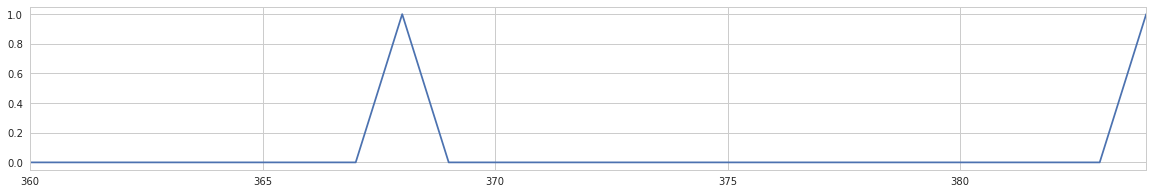

In [34]:
index = 360
pred_df.loc[index:index+24]['swell'].plot()

In [35]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
0        600 non-null int64
1        600 non-null float64
swell    600 non-null int64
dtypes: float64(1), int64(2)
memory usage: 14.1 KB


In [36]:
test['pred'] = pred_df['swell'].tolist()

In [60]:
index=576
test.sort_index().iloc[index:index+24].T.loc[['pred']]

hour  2017121107  2017121108  2017121109  2017121110  2017121111  2017121112  \
pred         0.0         0.0         0.0         1.0         0.0         1.0   

hour  2017121113  2017121114  2017121115  2017121116     ...      2017121121  \
pred         0.0         1.0         1.0         0.0     ...             0.0   

hour  2017121122  2017121123  2017121200  2017121201  2017121202  2017121203  \
pred         1.0         1.0         1.0         1.0         0.0         1.0   

hour  2017121204  2017121205  2017121206  
pred         1.0         0.0         0.0  

[1 rows x 24 columns]

In [50]:
mat =[]
for i in range(int(600/24)):
    index=24*i
    print(test.sort_index().iloc[index:index+24].T.loc[['pred']])
    mat.append(test.sort_index().iloc[index:index+24].T.loc['pred'].tolist())

hour  2014051807  2014051808  2014051809  2014051810  2014051811  2014051812  \
pred         1.0         1.0         1.0         1.0         1.0         1.0   

hour  2014051813  2014051814  2014051815  2014051816     ...      2014051821  \
pred         1.0         1.0         1.0         1.0     ...             1.0   

hour  2014051822  2014051823  2014051900  2014051901  2014051902  2014051903  \
pred         1.0         1.0         1.0         1.0         1.0         1.0   

hour  2014051904  2014051905  2014051906  
pred         1.0         1.0         1.0  

[1 rows x 24 columns]
hour  2014070607  2014070608  2014070609  2014070610  2014070611  2014070612  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2014070613  2014070614  2014070615  2014070616     ...      2014070621  \
pred         0.0         0.0         0.0         0.0     ...             0.0   

hour  2014070622  2014070623  2014070700  2014070701  2014070702  2014070703  \
pred  

[1 rows x 24 columns]
hour  2016113007  2016113008  2016113009  2016113010  2016113011  2016113012  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2016113013  2016113014  2016113015  2016113016     ...      2016113021  \
pred         0.0         0.0         0.0         0.0     ...             0.0   

hour  2016113022  2016113023  2016120100  2016120101  2016120102  2016120103  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2016120104  2016120105  2016120106  
pred         0.0         0.0         0.0  

[1 rows x 24 columns]
hour  2016122607  2016122608  2016122609  2016122610  2016122611  2016122612  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2016122613  2016122614  2016122615  2016122616     ...      2016122621  \
pred         0.0         0.0         0.0         0.0     ...             0.0   

hour  2016122622  2016122623  2016122700  2016122701  2016122702

In [59]:
pd.DataFrame(np.array(mat)).to_csv('./sub_swell.csv')